# Extração dos dados de TEC para as estações escolhidas
___

Os dados da série temporal para o TEC consiste de uma matriz para cada instante de tempo. Dado uma latitude e longitude é possível mapear para um par $(i, j)$ correspondendo a uma entrada da matriz. O papel deste notebook é varrer a série e extrair os dados de apenas algumas estações, isto é, dada a sua localização, é possível extrair da matriz um valor de tec. A coleção de valores extraídos ao longo do tempo, para uma dada estação, gera uma série temporal para esta.

Além da extração dos dados, uma suavização é aplicado as séries temporais encontradas.

In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.signal import savgol_filter

import utils

from utils import local_data
from utils import window

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# load dataframe of stations
# load series of tec data
# load series of tec data first order derivative
# load series of tec data second order derivative

files = ['data_series_tec.pkl.xz']
df_station = pd.read_pickle(os.path.join(local_data, 'df_station_sort.pkl'))

In [3]:
df_station

,identificationstation,alias,height,latitude,longitude,network,state,city,startoperation,stopoperation,city_heigh,city_latitude,city_longitude,mag_latitude,mag_longitude
city_name_correct,,,,,,,,,,,,,,,
Alta Floresta,afl,null,267.000,-9.870000,-55.900000,septentrio,mt,alta floresta,NaN,NaN,264.0,-9.90000,-55.9000,-11.812189,16.212312
Belo Horizonte,bhz,null,858.000,-19.868500,-43.954200,lisn,mg,belo horizonte,NaN,NaN,767.0,-19.81570,-43.9542,-25.426147,24.786619
Boa Vista,bov,null,69.180,2.833920,-60.695380,lisn,rr,boa vista,NaN,NaN,76.0,2.81954,-60.6714,11.622177,14.848847
Brasília,bsa,null,1050.000,-15.764200,-47.869400,lisn,df,brasilia,NaN,NaN,1130.0,-15.78010,-47.9292,-24.348659,22.352744
Cachoeira Paulista,cpa,null,580.000,-22.410000,-45.000000,lisn,sp,cachoeira paulista,NaN,NaN,545.0,-22.67370,-44.9973,-24.456556,22.960540
Campo Grande,32,cg01,NaN,-20.497000,-54.615000,septentrio,ms,campos grande,NaN,NaN,612.0,-20.44350,-54.6478,-21.417704,14.873907
Cuiabá,cub,null,278.000,-15.555200,-56.069800,lisn,mt,cuiaba,NaN,NaN,180.0,-15.59890,-56.0949,-14.336068,14.530440
Dourados,dou,null,756.120,-22.110000,-54.550000,lisn,ms,dourados,NaN,NaN,448.0,-22.22180,-54.8064,-23.627266,14.698554
Fortaleza,24,fort,NaN,-3.742000,-38.539000,septentrio,ce,fortaleza,NaN,NaN,14.0,-3.71839,-38.5434,NaN,NaN


In [4]:
def extract_series_station_from_array(df, list_of_stations, window):
    data = utils.extract_vtec(df)
    # generate panda dataframe of timestamps, where there are tec information
    df_series = pd.DataFrame(index=utils.extract_index(df))
    
    for row in list_of_stations:
        i, j = utils.ij_par(row.longitude, row.latitude)
        series = [float(vtec_matrix[i][j]) for vtec_matrix in data]
        df_series[row.identificationstation] = series
    
    return df_series

In [5]:
abs_path = os.path.join(local_data, files[0])
df_series = extract_series_station_from_array(pd.read_pickle(abs_path), 
                                              df_station.itertuples(), 
                                              window)

In [6]:
sj2_values = df_series['sj2'].values
df = pd.DataFrame(df_series['sj2'])
df.columns = ['São José dos Campos']
rolling = df.rolling(window, win_type='gaussian', center=True)
df['São José dos Campos após suavização com média móvel com peso gaussiano'] = rolling.mean(std=1.0)
df['São José dos Campos após suavização com filtro de Savint'] = savgol_filter(sj2_values, window, 3)

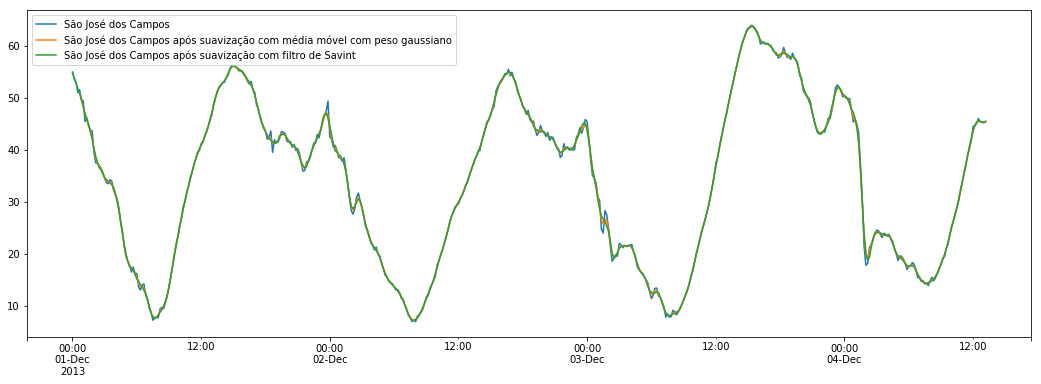

In [7]:
# just for visualization
df[0:512].plot(figsize=(18, 6));
plt.savefig('./images/vtec_sj2.eps', format='eps', dpi=1000)

In [8]:
for i in df_series.columns.values:
    df_series[i] = savgol_filter(df_series[i].values, window, 3)
    

rolling = df_series.rolling(window, win_type='gaussian', center=True)
df_series = rolling.mean(std=1.0)

In [9]:
columns = [i for i in df_series.columns.values]
name = [df_station.loc[df_station['identificationstation'] == i].index[0] for i in columns]
df_series_draw = df_series.copy()
df_series_draw.columns = name


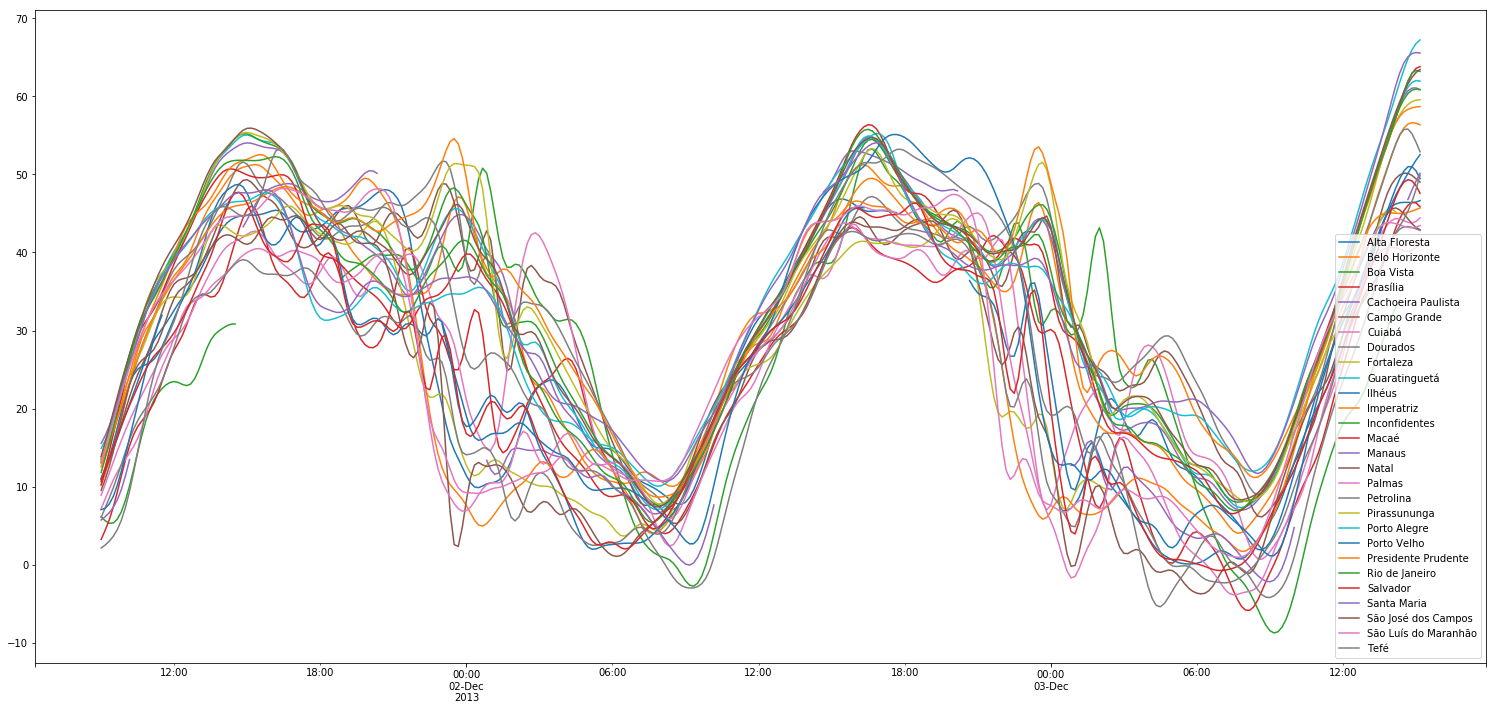

In [10]:
# just for visualization
df_series_draw[50:384].rolling(window, win_type='gaussian', center=True).mean(std=1.0).plot(figsize=(26, 12));
plt.savefig('./images/vtec_signal.eps', format='eps', dpi=1000)

In [11]:
for file in files:
    df_series.to_pickle(os.path.join(local_data, 'station_' + file), compression='xz')